### 第六章作业
阅读Otsu及基于感兴趣区内的背景范围先验知识文章，实现二类的Otsu算法RCOtsu算法并对图像MRA图像实施相应的二值化并讨论优劣  
（分割出亮的区域，即血管）（2学时）。

### Otsu以及RCOtsu介绍：
OTSU算法也称最大类间差法，有时也称之为大津算法，由大津于1979年提出，被认为是图像分割中阈值选取的最佳算法，计算简单，不受图像亮度和对比度的影响，因此在数字图像处理上得到了广泛的应用。 它是按图像的灰度分布特性,将图像分成背景(background)和目标(object)两部分。
Otsu算法采用聚类的思想，将灰度图像整体分为两类，通过使得类间方差最大化的方式找到目标灰度阈值。但是对于双峰或多峰的情况或者目标区域整体区域占比很小时，往往不能直接分离出目标区域。  
RCOtsu的算法是基于Otsu之上，结合先验知识针对感兴趣区域（ROI）进行处理。其效果往往要优于Otsu，但难点在于得到感兴趣区域。


In [86]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
#Opencv配合jupyter notebook有问题，所以还是使用matplotlib可视化
%matplotlib inline
from matplotlib.image import imread

In [87]:
#获取待处理图像MRA_ori
MRA_ori = imread("MRA.pgm")
MRA_ori.shape

(69, 138)

In [88]:
#获取真值图像MRA_ref
MRA_ref = cv.imread("MRA_Reference.pgm")
MRA_ref = cv.cvtColor(MRA_ref,cv.COLOR_RGB2GRAY)#转换为灰度图
MRA_ref.shape

(69, 138)

Text(0.5, -0.1, 'Original')

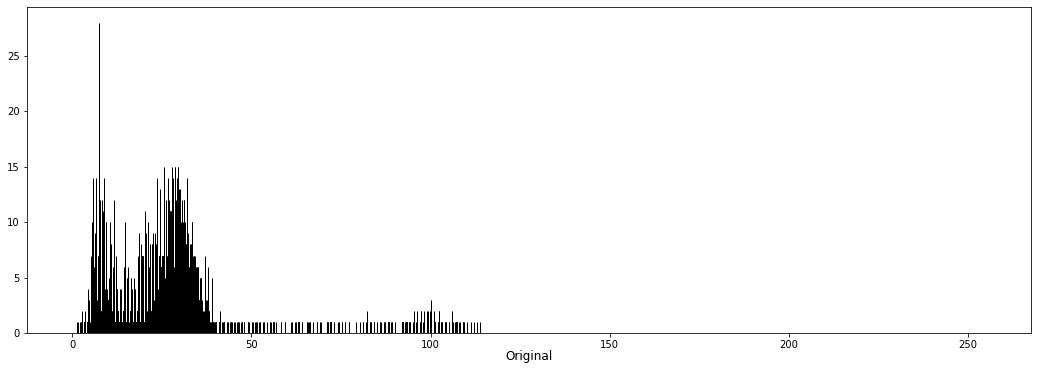

In [89]:
#观察原图像的灰度直方图
plt.figure(figsize=(18,6))
plt.hist(MRA_ori, bins=256, range=(0, 255), fc='k', ec='k')
plt.title('Original',x=0.5,y=-0.1) 

可以观察到这幅图像有两个峰，对应图像中两大部分的灰度区域。  
若直接使用Otsu算法，可以预见会将大片的前景和后景分离，但无法得到想要的血管的分离图像。

(<matplotlib.image.AxesImage at 0x7f9e129e1b50>, 20.0)

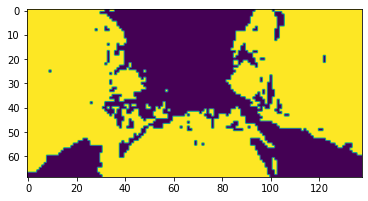

In [90]:
thred_1,otsu_img = cv.threshold(MRA_ori,0,255,cv.THRESH_OTSU)
plt.imshow(otsu_img),thred_1

直接使用Otsu，找到20为阈值，但如前面预料的那样分离的是大面积的背景而非感兴趣的区域  
使用RCOtsu的思路即先找到感兴趣区域(ROI)，再在感兴趣的区域进行Otsu分离，可以得到较好的效果。
下面就来找兴趣区(ROI)

### 方法一： 通过其他类似图像的金标准增加裕值
### 方法二： 通过手动标注等方法得到大致轮廓再增加一定裕值
由于这里没有其他更多的先验知识，接下来假定真值图片是通过其他类似图片得到的真值作为参考，或者是通过手动标注得到的大致轮廓。  
接着以真值/参考的轮廓范围套入原图中，以得到对应的灰度范围，并适当增加占比2%的空间，作为感兴趣区域。

Text(0.5, -0.1, 'Ground truth')

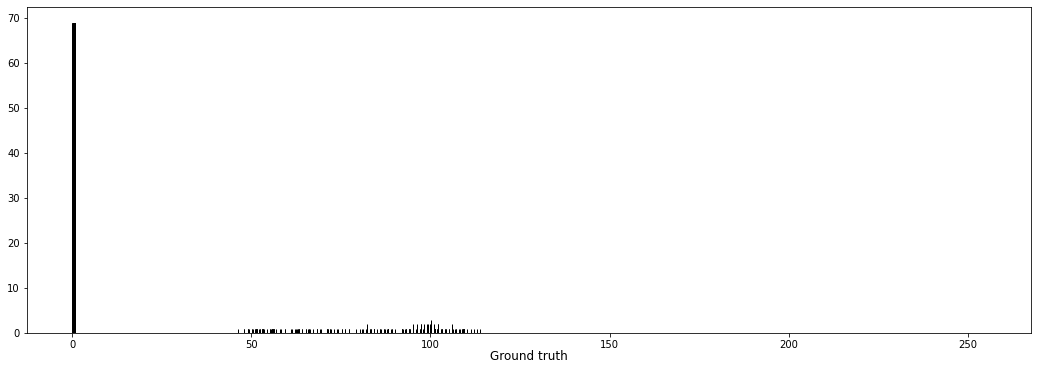

In [91]:
#利用(0,1)二值化的真值图与原图像像素各自相乘，从而得到感兴趣区域的灰度分布情况
MRA_ref_new = MRA_ref/255
MRA_roi = np.array(MRA_ref_new)*np.array(MRA_ori)
plt.figure(figsize=(18,6))
plt.hist(MRA_roi, bins=256, range=(0, 255), fc='k', ec='k')
plt.title('Ground truth',x=0.5,y=-0.1) 

In [92]:
MRA_roi.max()#可以得知感兴趣范围大致在45～114之间，适当扩大范围至30～150

114.0

### 对ROI区域进行Otsu处理
Opencv中自带的Otsu方法如下，仅能对整张图像的全部(0，255)进行最大类间方差计算，而应用到RCOtsu上时会非常麻烦。
`ret, otsu = cv.threshold(img,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)`
因此我们对其原方法进行改写拓展，使其可以对特定灰度直方图区域进行Otsu处理，如：
$$
RCOtsu=(img,m,n)
\\其中img为待处理的灰度图像(灰度须为0:255),m为感兴趣区域灰度的左边界，n为右边界
$$
下面可以看到现在可以很方便的应用RCOtsu得到图像。


In [93]:
#对Opencv里的Otsu's Binarization方法进行改写，使得便于直接计算限定灰度范围(m,n)里的Otsu下的阈值
def RCOtsu(img,m,n):#m表示ROI的灰度下届，n表示灰度上届
    blur = cv.GaussianBlur(img,(5,5),0)
    # find normalized_histogram, and its cumulative distribution function
    hist = cv.calcHist([blur],[0],None,[n-m+1],[m,n])#只计算保留[m,n]灰度区间内的灰度统计信息
    hist_norm = hist.ravel()/hist.sum()
    Q = hist_norm.cumsum()
    bins = np.arange(n-m+1)
    fn_min = np.inf
    thresh = -1
    for i in range(m,n+1):#只在[m,n]灰度区间内进行计算
        #由于hist_norm和Q的index是从0开始的，所以下面index值需要更改为[i-m]，最大值为[n-m]
        p1,p2 = np.hsplit(hist_norm,[i-m]) # probabilities
        q1,q2 = Q[i-m],Q[n-m]-Q[i-m] # cum sum of classes
        if q1 < 1.e-6 or q2 < 1.e-6:
            continue
        b1,b2 = np.hsplit(bins,[i-m]) # weights
        # finding means and variances
        m1,m2 = np.sum(p1*b1)/q1, np.sum(p2*b2)/q2
        v1,v2 = np.sum(((b1-m1)**2)*p1)/q1,np.sum(((b2-m2)**2)*p2)/q2
        # calculates the minimization function
        fn = v1*q1 + v2*q2
        if fn < fn_min:
            fn_min = fn
            thresh = i
    # find otsu's threshold value with OpenCV function
    ret, otsu = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    print( "{} {}".format(thresh,ret) )#对比更改后的算法得到的阈值与原始otsu阈值的结果
    t1, new_img = cv.threshold(img,thresh,255,cv.THRESH_TOZERO)
    return thresh,new_img


58 20.0


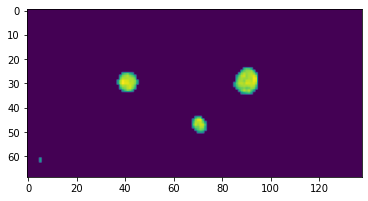

In [94]:
thred_2, rcotsu_img = RCOtsu(MRA_ori,30,150)#对感兴趣区域30:150进行Otsu处理
plt.imshow(rcotsu_img)

### 结果与讨论

Text(0.5, -0.2, 'RCOtsu')

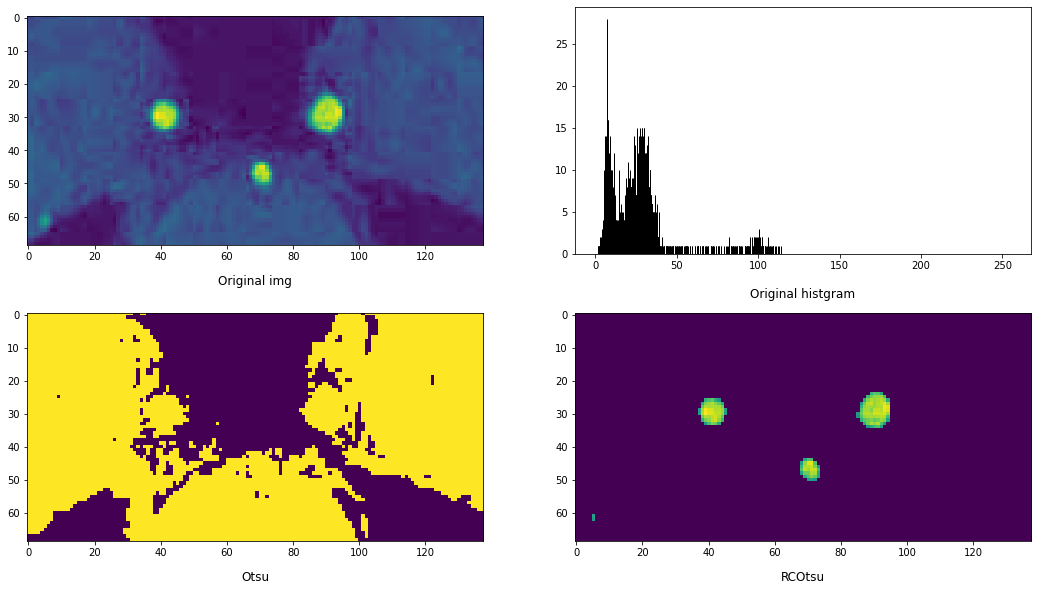

In [99]:
plt.figure(figsize=(18, 10))
plt.subplot(221)
plt.imshow(MRA_ori)
plt.title('Original img',x=0.5,y=-0.2)
plt.subplot(222)
plt.hist(MRA_ori, bins=256, range=(0, 255), fc='k', ec='k')
plt.title('Original histgram',x=0.5,y=-0.2) 
plt.subplot(223)
plt.imshow(otsu_img)
plt.title('Otsu',x=0.5,y=-0.2)
plt.subplot(224)
plt.imshow(rcotsu_img)
plt.title('RCOtsu',x=0.5,y=-0.2)


Text(0.5, -0.2, 'RCOtsu')

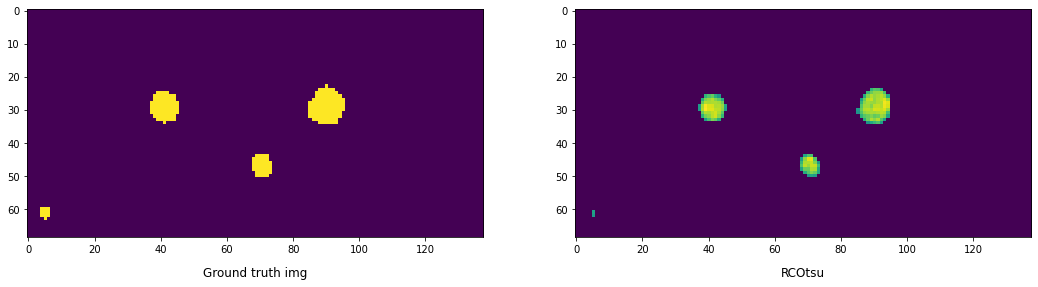

In [100]:
plt.figure(figsize=(18, 10))
plt.subplot(121)
plt.imshow(MRA_ref)
plt.title('Ground truth img',x=0.5,y=-0.2)
plt.subplot(122)
plt.imshow(rcotsu_img)
plt.title('RCOtsu',x=0.5,y=-0.2)

Otsu算法实现的是聚类效果，可以快速、简便地区分出图像的前景和背景，尤其对单峰分布的图像具有很好的效果。
但它的缺点也很明显，也正如上面结果所示，对灰度分布复杂的多峰图像，往往不能很好的将目标区域与其他区域分割开来。  
RCOtsu算法则由于考虑到了先验知识，划分出感兴趣区域，因此其图像分割的效果往往更好。但是难在批量寻找到准确的ROI，需要较大人力或其他信息来获得可靠的先验信息。